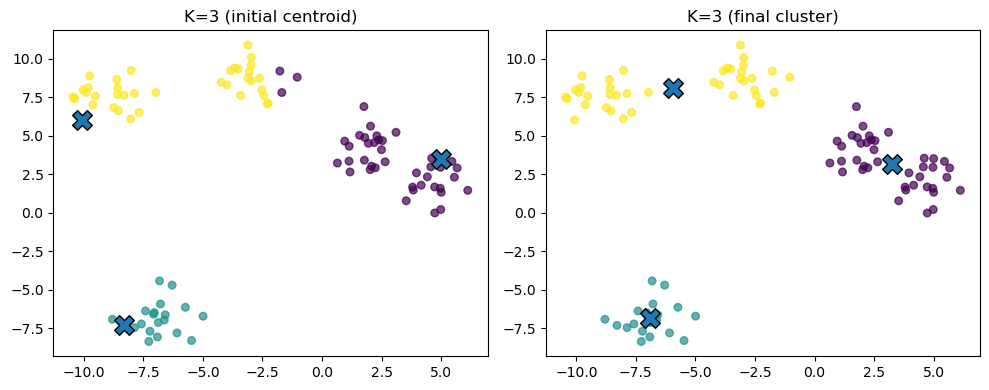

K=3: Rand Index = 0.8384, Silhouette Score = 0.7081


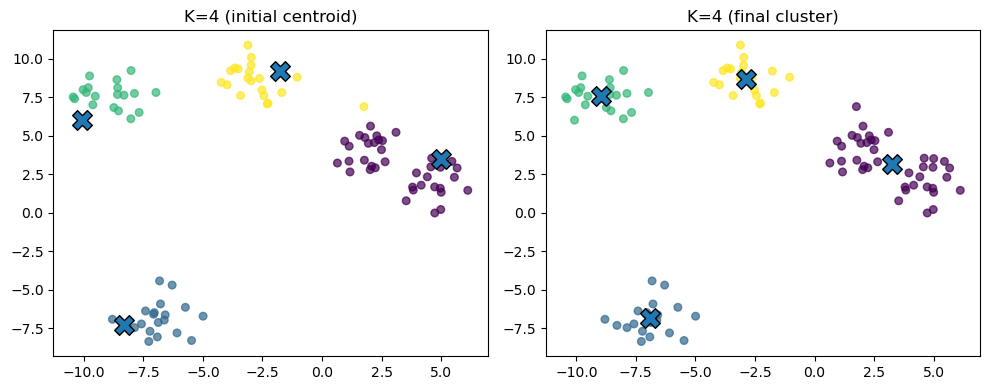

K=4: Rand Index = 0.9192, Silhouette Score = 0.7280


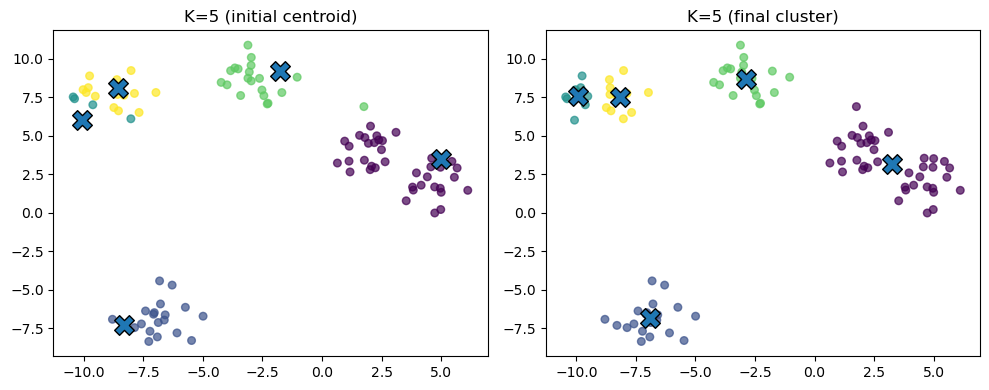

K=5: Rand Index = 0.8992, Silhouette Score = 0.6576


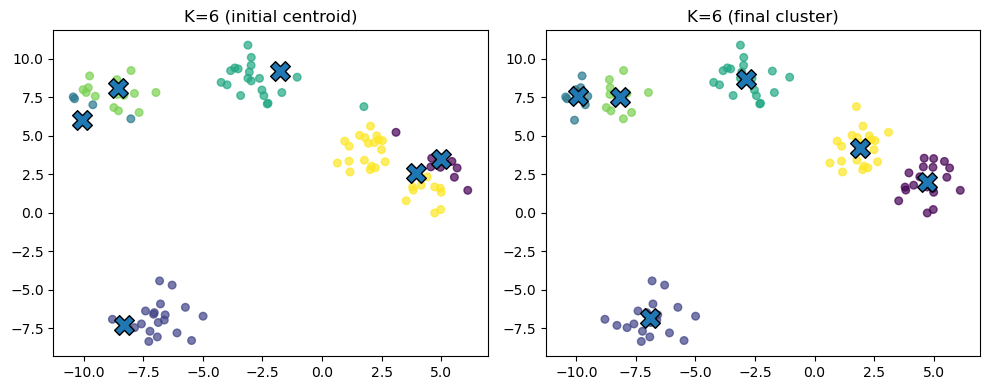

K=6: Rand Index = 0.9721, Silhouette Score = 0.6258


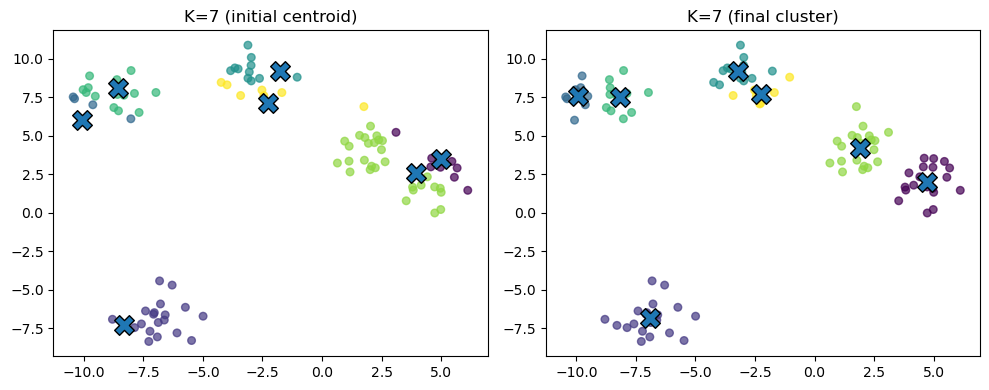

K=7: Rand Index = 0.9537, Silhouette Score = 0.5671


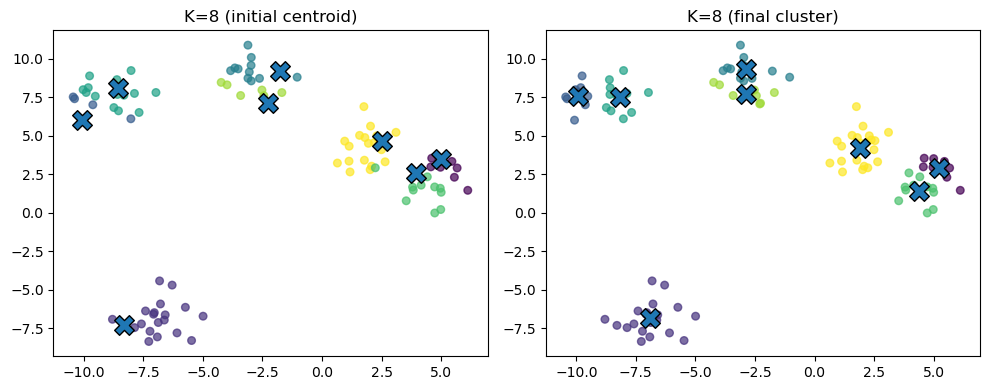

K=8: Rand Index = 0.9349, Silhouette Score = 0.5110

=== 최적 K (Rand Index 기준) ===
  -> K = 6, 점수 = 0.9721

=== 최적 K (Silhouette Score 기준) ===
  -> K = 4, 점수 = 0.7280


In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.metrics import rand_score, silhouette_score

# --------------------------------------------------
# 1. 데이터 생성 (make_blobs)
#    - n_samples=100, n_features=2, centers=5
# --------------------------------------------------
RANDOM_STATE = 42

X, y_true = make_blobs(
    n_samples=100,
    n_features=2,
    centers=5,
    cluster_std=1.0,
    random_state=RANDOM_STATE
)

# --------------------------------------------------
# 2. K-means 직접 구현 함수들
#    (scikit-learn의 KMeans 사용 금지)
# --------------------------------------------------
def init_centroids(X, k, rng):
   
    n_samples = X.shape[0]
    indices = rng.choice(n_samples, size=k, replace=False)
    return X[indices].copy()

def assign_clusters(X, centroids):
   
    # 거리 행렬: (n_samples, k)
    distances = np.linalg.norm(
        X[:, np.newaxis, :] - centroids[np.newaxis, :, :],
        axis=2
    )
    labels = np.argmin(distances, axis=1)
    return labels

def update_centroids(X, labels, k, rng):
  
    n_features = X.shape[1]
    centroids = np.zeros((k, n_features))

    for cluster_id in range(k):
        members = X[labels == cluster_id]
        if len(members) == 0:
            # 비어 있는 클러스터면 랜덤한 점으로 재설정
            centroids[cluster_id] = X[rng.randint(0, X.shape[0])]
        else:
            centroids[cluster_id] = members.mean(axis=0)

    return centroids

def run_kmeans(X, k, max_iters=100, tol=1e-4, random_state=None):
   
    rng = np.random.RandomState(random_state)

    # (1) 초기 centroid 설정
    centroids = init_centroids(X, k, rng)
    init_centroids_ = centroids.copy()

    # (2) '시작되기 전' 상태용 초기 라벨 (한 번 할당해 둔다)
    init_labels = assign_clusters(X, centroids)

    # (3) 반복 업데이트
    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k, rng)

        # centroid 이동량으로 수렴 여부 판단
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids

        if shift < tol:
            # 더 이상 크게 변하지 않으면 종료
            break

    final_labels = labels
    final_centroids = centroids

    return init_labels, init_centroids_, final_labels, final_centroids

# --------------------------------------------------
# 3. K값 하나에 대해
#    '시작 전' / '종료 후' 그림을 그리는 함수
# --------------------------------------------------
def plot_kmeans_result(X,
                       init_labels, init_centroids,
                       final_labels, final_centroids,
                       k):
   
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # --- 시작 전 ---
    ax = axes[0]
    scatter1 = ax.scatter(X[:, 0], X[:, 1],
                          c=init_labels, s=30, alpha=0.7)
    ax.scatter(init_centroids[:, 0], init_centroids[:, 1],
               marker='X', s=200, edgecolors='k')
    ax.set_title(f"K={k} (initial centroid)")

    # --- 종료 후 ---
    ax = axes[1]
    scatter2 = ax.scatter(X[:, 0], X[:, 1],
                          c=final_labels, s=30, alpha=0.7)
    ax.scatter(final_centroids[:, 0], final_centroids[:, 1],
               marker='X', s=200, edgecolors='k')
    ax.set_title(f"K={k} (final cluster)")

    plt.tight_layout()
    plt.show()

# --------------------------------------------------
# 4. K = 3,4,5,6,7,8에 대해
#    - K-means 실행
#    - 초기/종료 그림 출력
#    - Rand Index, Silhouette score 계산
# --------------------------------------------------
Ks = [3, 4, 5, 6, 7, 8]

rand_scores = {}
sil_scores = {}

for k in Ks:
    init_labels, init_centroids_arr, final_labels, final_centroids_arr = run_kmeans(
        X, k,
        max_iters=200,
        tol=1e-4,
        random_state=RANDOM_STATE
    )

    # (1) 그림 출력
    plot_kmeans_result(
        X,
        init_labels, init_centroids_arr,
        final_labels, final_centroids_arr,
        k
    )

    # (2) Rand index, Silhouette score 계산
    #  - Rand index는 make_blobs가 생성한 y_true와 비교
    ri = rand_score(y_true, final_labels)
    ss = silhouette_score(X, final_labels)

    rand_scores[k] = ri
    sil_scores[k] = ss

    print(f"K={k}: Rand Index = {ri:.4f}, Silhouette Score = {ss:.4f}")

# --------------------------------------------------
# 5. [3,8]에서 각 점수 기준 최적 K 출력
# --------------------------------------------------
best_k_rand = max(rand_scores, key=rand_scores.get)
best_k_sil = max(sil_scores, key=sil_scores.get)

print("\n=== 최적 K (Rand Index 기준) ===")
print(f"  -> K = {best_k_rand}, 점수 = {rand_scores[best_k_rand]:.4f}")

print("\n=== 최적 K (Silhouette Score 기준) ===")
print(f"  -> K = {best_k_sil}, 점수 = {sil_scores[best_k_sil]:.4f}")
